In [1]:
import sys
from tqdm import tqdm
from sklearn.random_projection import SparseRandomProjection, GaussianRandomProjection

# from scipy.stats import kurtosis, skew
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score,ParameterGrid
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

sys.path.append("../")
from utils import load_data, StrokeParams, FetalHealthParams

RANDOM_STATE = 666


def project_data(X, n_components, projection_type="sparse", random_state=None, **kwargs):
    """
    Projects the data X into a lower-dimensional space using random projection.
    """
    # Choose the projection type
    if projection_type == "sparse":
        transformer = SparseRandomProjection(
            n_components=n_components, random_state=random_state, **kwargs
        )
    else:
        transformer = GaussianRandomProjection(
            n_components=n_components, random_state=random_state, **kwargs
        )

    # Perform the projection
    X_projected = transformer.fit_transform(X)
    return X_projected, transformer


def calculate_reconstruction_error(X, X_projected, transformer):
    """
    Calculates the reconstruction error between the original and projected data.
    """
    # Reconstruct data from the projection
    X_reconstructed = transformer.inverse_transform(X_projected)
    # Calculate the error metric, e.g., MSE
    error = mean_squared_error(X, X_reconstructed)
    return error


def cross_validate_rp(
    X, n_components, n_splits=5, projection_type="sparse", random_state=None
):
    """
    Applies cross-validation to evaluate the reconstruction error of random projection.

    Parameters:
    - X: The input data.
    - n_components: The number of components for random projection.
    - n_splits: The number of splits for cross-validation.
    - projection_type: 'sparse' for SparseRandomProjection, 'gaussian' for GaussianRandomProjection.
    - random_state: The random state for reproducibility.

    Returns:
    - mean_reconstruction_error: The average reconstruction error over all cross-validation folds.
    - std_reconstruction_error: The standard deviation of the reconstruction error.
    """

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    reconstruction_errors = []

    for train_index, _ in kf.split(X):
        X_train = X.iloc[train_index]

        # Project and reconstruct the data using defined functions
        X_projected, transformer = project_data(
            X_train, n_components, projection_type, random_state
        )
        error = calculate_reconstruction_error(X_train, X_projected, transformer)

        reconstruction_errors.append(error)

    mean_reconstruction_error = np.mean(reconstruction_errors)
    std_reconstruction_error = np.std(reconstruction_errors)

    return mean_reconstruction_error, std_reconstruction_error


def grid_search_rp(X, n_components, projection_type="sparse", random_state=None):
    """
    Applies grid search to evaluate the reconstruction error of random projection
    for different configurations of parameters specific to each projection type.

    Parameters:
    - X: The input data.
    - n_components: The number of components for random projection.
    - projection_type: 'sparse' for SparseRandomProjection, 'gaussian' for GaussianRandomProjection.
    - random_state: The random state for reproducibility.

    Returns:
    - best_configuration: The configuration with the lowest reconstruction error.
    - min_reconstruction_error: The minimum reconstruction error achieved.
    """

    if projection_type == "sparse":
        param_grid = {'density': [0.1, 0.25, 0.5, 0.75, 1.0]}
    else:
        param_grid = {'eps': [0.01, 0.05, 0.1, 0.3, 0.5]}

    best_configuration = None
    min_reconstruction_error = float('inf')

    for params in ParameterGrid(param_grid):
        X_projected, transformer = project_data(X, n_components, projection_type, random_state, **params)
        error = calculate_reconstruction_error(X, X_projected, transformer)

        if error < min_reconstruction_error:
            min_reconstruction_error = error
            best_configuration = params

    return best_configuration, min_reconstruction_error


def rp_experiment(
    X, n_components_range, projection_type="sparse", random_state=None, n_splits=5
):
    """
    Iterates over a range of components to perform random projection and calculate reconstruction error using cross-validation.

    Parameters:
    - X: Data to project.
    - n_components_range: Range of component numbers to test.
    - projection_type: 'sparse' or 'gaussian' for the type of random projection.
    - random_state: Seed for reproducibility.
    - n_splits: Number of splits for cross-validation.

    Returns:
    - DataFrame with the results.
    """
    results = []
    configurations = {}

    for n_components in tqdm(n_components_range):
        # # Perform cross-validation and get average reconstruction error and its standard deviation
        # avg_error, std_error = cross_validate_rp(
        #     X,
        #     n_components,
        #     n_splits=n_splits,
        #     projection_type=projection_type,
        #     random_state=random_state,
        # )

        # # Append results
        # results.append(
        #     {
        #         "n_components": n_components,
        #         "avg_reconstruction_error": avg_error,
        #         "std_reconstruction_error": std_error,
        #     }
        # )

        # perform grid search
        best_configuration, min_reconstruction_error = grid_search_rp(
            X, n_components, projection_type=projection_type, random_state=random_state
        )

        results.append({
            "n_components": n_components,
            "min_reconstruction_error": min_reconstruction_error,
        })

        configurations[n_components] = best_configuration

    return pd.DataFrame(results), configurations


# def plot_rp_results(results_df, title, save_path=None):
#     """
#     Plots the average reconstruction error and its standard deviation versus the number of components.

#     Parameters:
#     - results_df (DataFrame): DataFrame containing the experiment results, including 'n_components',
#       'avg_reconstruction_error', and 'std_reconstruction_error'.
#     - title (str): Title for the plot.
#     - save_path (str, optional): Path to save the plot image. If None, the plot is not saved.
#     """
#     plt.figure(figsize=(10, 6))
#     plt.errorbar(
#         results_df["n_components"],
#         results_df["avg_reconstruction_error"],
#         yerr=results_df["std_reconstruction_error"],
#         fmt="-o",
#         ecolor="lightgray",
#         elinewidth=3,
#         capsize=0,
#         color="blue",
#         label="Reconstruction Error ± STD",
#     )

#     plt.title(title)
#     plt.xlabel("Number of Components")
#     plt.ylabel("Average Reconstruction Error")
#     plt.xticks(results_df["n_components"])
#     plt.legend()
#     plt.grid(True)

#     if save_path:
#         plt.savefig(save_path, bbox_inches="tight")
#     plt.show()

def plot_rp_results(results_df, title, threshold=None, save_path=None):
    """
    Plots the minimum reconstruction error versus the number of components based on grid search results and optionally a threshold for acceptable error.

    Parameters:
    - results_df (DataFrame): DataFrame containing the experiment results, including 'n_components' and 'min_reconstruction_error'.
    - title (str): Title for the plot.
    - threshold (float, optional): A threshold value for acceptable error. If provided, a horizontal line is drawn at this value.
    - save_path (str, optional): Path to save the plot image. If None, the plot is not saved.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(
        results_df["n_components"],
        results_df["min_reconstruction_error"],
        marker='o',
        linestyle='-',
        color='blue',
        label='Minimum Reconstruction Error',
    )

    # Plot threshold line if provided
    if threshold is not None:
        plt.axhline(y=threshold, color='red', linestyle='--', label=f'Error Threshold ({threshold})')

    plt.title(title)
    plt.xlabel("Number of Components")
    plt.ylabel("Minimum Reconstruction Error")
    plt.xticks(results_df["n_components"])
    plt.legend()
    plt.grid(True)

    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
    plt.show()


if __name__ == "__main__":
    # load data
    strokeX_all, strokeY = load_data(
        StrokeParams.data_train, StrokeParams.target_column
    )
    strokeX = strokeX_all.drop(columns=StrokeParams.cat_cols)
    fetalX_all, fetalY = load_data(
        FetalHealthParams.data_train, FetalHealthParams.target_column
    )
    fetalX = fetalX_all.drop(columns=FetalHealthParams.cat_cols)

100%|██████████| 1/1 [00:00<00:00, 103.33it/s]

Stroke Dataset RP (sparse) Results:


,n_components,min_reconstruction_error
0,2,0.219629


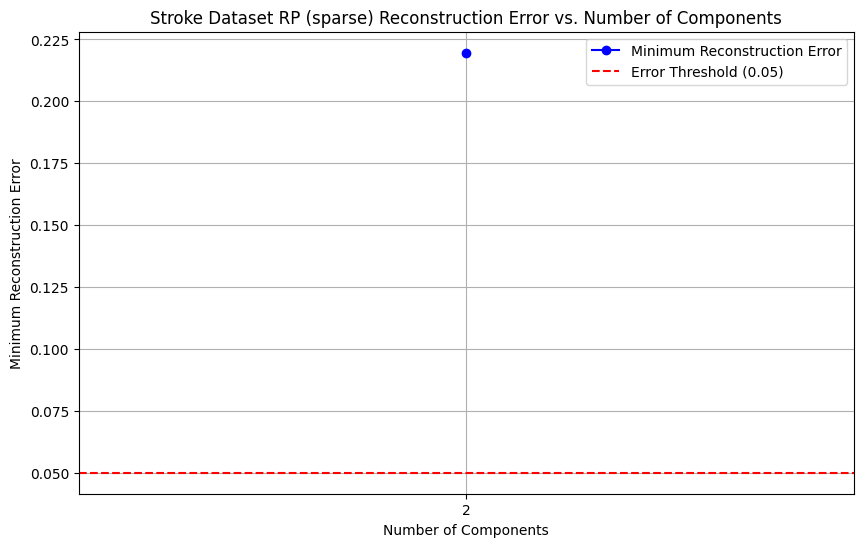

100%|██████████| 1/1 [00:00<00:00, 69.71it/s]

Stroke Dataset RP (gaussian) Results:


,n_components,min_reconstruction_error
0,2,0.327042


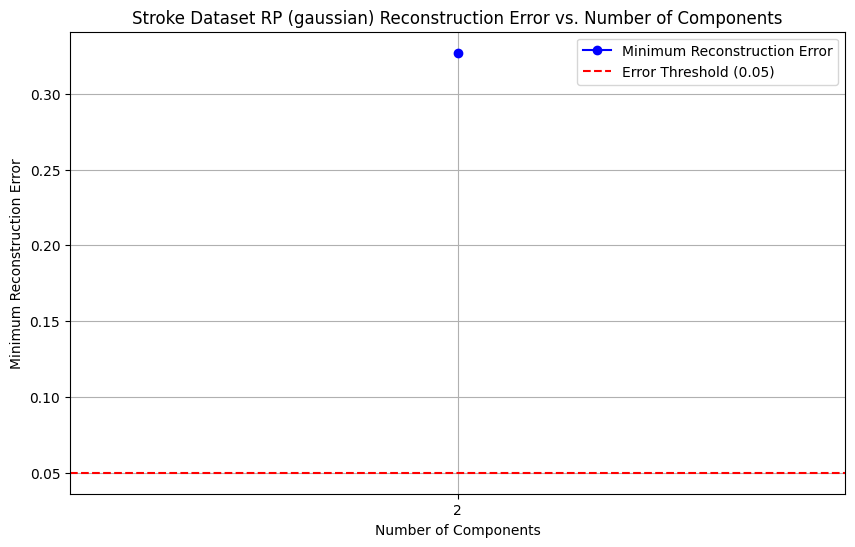

In [2]:
if __name__ == "__main__":
    n_components_range = [2]

    for projection_type in ["sparse", "gaussian"]:
        # Perform the RP experiment
        stroke_rp_results, stroke_rp_configurations = rp_experiment(
            X=strokeX,
            n_components_range=n_components_range,
            projection_type=projection_type,
            random_state=RANDOM_STATE,
            n_splits=5,
        )

        # Print results
        print(f"Stroke Dataset RP ({projection_type}) Results:")
        display(stroke_rp_results)

        # Visualize the results
        plot_rp_results(
            stroke_rp_results,
            f"Stroke Dataset RP ({projection_type}) Reconstruction Error vs. Number of Components",
            save_path=f"stroke_rp_{projection_type}.png",
            threshold=0.05,
        )

100%|██████████| 18/18 [00:06<00:00,  2.65it/s]

Stroke Dataset (all) RP (sparse) Results:


,n_components,min_reconstruction_error
0,19,3.712206e-30
1,18,3.896941e-02
2,17,7.996355e-02
3,16,1.494555e-01
4,15,1.954683e-01
5,14,2.376196e-01
6,13,2.898206e-01
7,12,3.497916e-01
8,11,4.041695e-01
9,10,4.469232e-01


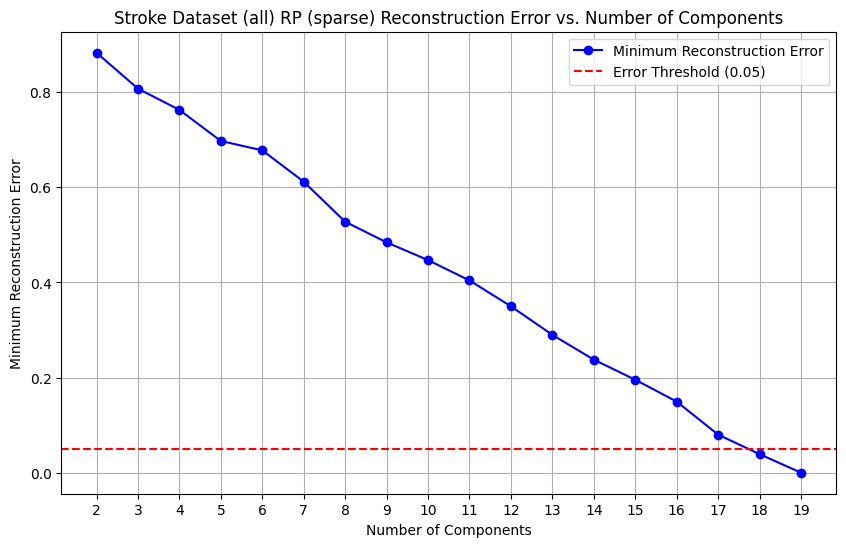

100%|██████████| 18/18 [00:11<00:00,  1.58it/s]

Stroke Dataset (all) RP (gaussian) Results:


,n_components,min_reconstruction_error
0,19,4.934006e-29
1,18,4.420938e-02
2,17,1.218760e-01
3,16,2.046250e-01
4,15,2.438330e-01
5,14,2.839078e-01
6,13,3.394044e-01
7,12,4.032058e-01
8,11,4.474636e-01
9,10,5.213685e-01


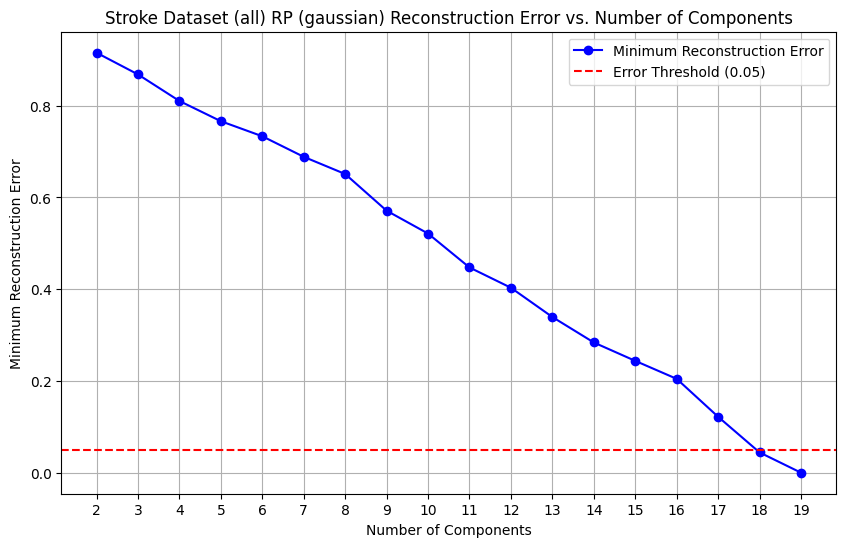

In [3]:
if __name__ == "__main__":
    n_components_range = list(range(2, strokeX_all.shape[1] + 1))[::-1]

    for projection_type in ["sparse", "gaussian"]:
        # Perform the RP experiment
        stroke_rp_results, stroke_rp_configurations = rp_experiment(
            X=strokeX_all,
            n_components_range=n_components_range,
            projection_type=projection_type,
            random_state=RANDOM_STATE,
            n_splits=5,
        )

        # Print results
        print(f"Stroke Dataset (all) RP ({projection_type}) Results:")
        display(stroke_rp_results)

        # Visualize the results
        plot_rp_results(
            stroke_rp_results,
            f"Stroke Dataset (all) RP ({projection_type}) Reconstruction Error vs. Number of Components",
            save_path=f"stroke_all_rp_{projection_type}.png",
            threshold=0.05,
        )

100%|██████████| 17/17 [00:00<00:00, 19.32it/s]

Fetal Health Dataset RP (sparse) Results:


,n_components,min_reconstruction_error
0,18,3.165035e-30
1,17,3.275962e-02
2,16,8.956743e-02
3,15,1.182494e-01
4,14,1.918309e-01
5,13,2.465306e-01
6,12,3.050809e-01
7,11,3.147835e-01
8,10,3.917238e-01
9,9,4.249917e-01


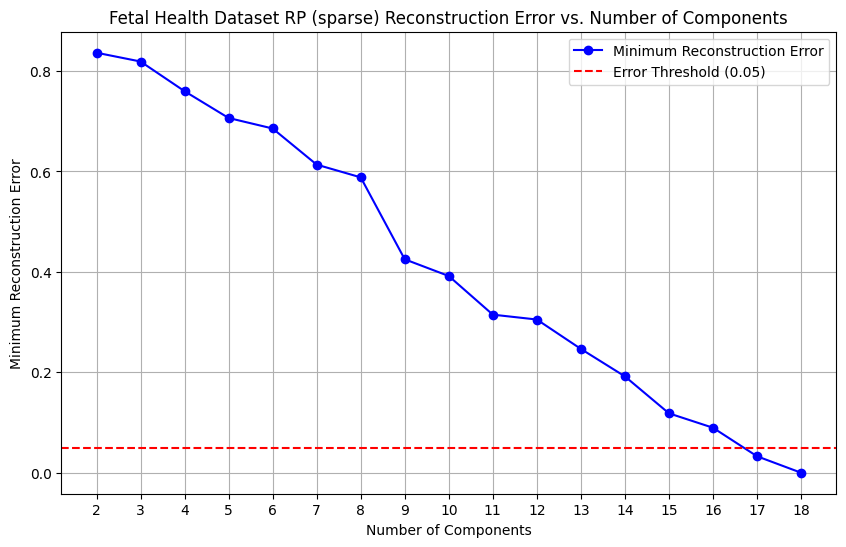

100%|██████████| 17/17 [00:08<00:00,  2.00it/s]

Fetal Health Dataset RP (gaussian) Results:


,n_components,min_reconstruction_error
0,18,3.835627e-30
1,17,4.128666e-02
2,16,1.028720e-01
3,15,1.746270e-01
4,14,2.319250e-01
5,13,2.776810e-01
6,12,3.168156e-01
7,11,3.574277e-01
8,10,3.862745e-01
9,9,4.624377e-01


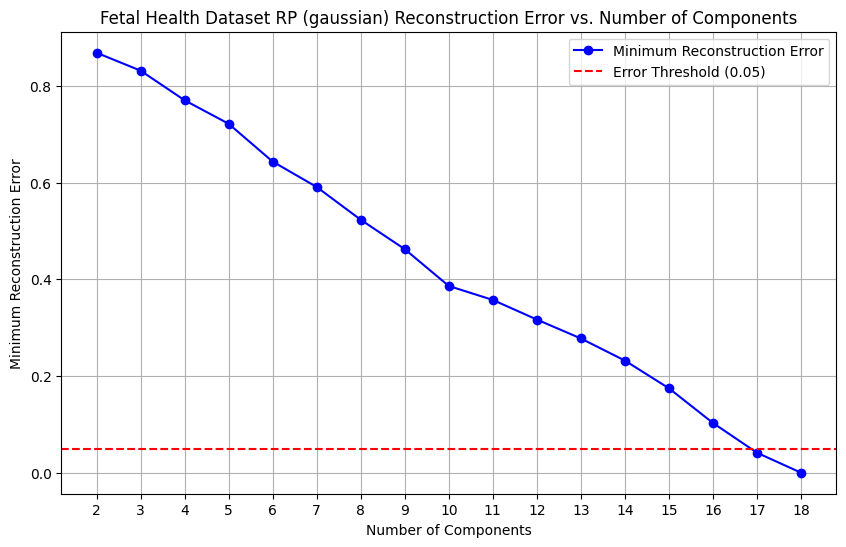

In [4]:
if __name__ == "__main__":
    # Set the range for the number of components
    n_components_range = list(range(2, fetalX.shape[1] + 1))[::-1]

    for projection_type in ["sparse", "gaussian"]:
        # Perform the RP experiment
        fetal_rp_results, fetal_rp_configurations = rp_experiment(
            X=fetalX,
            n_components_range=n_components_range,
            projection_type=projection_type,
            random_state=RANDOM_STATE,
            n_splits=5,
        )

        # Print results
        print(f"Fetal Health Dataset RP ({projection_type}) Results:")
        display(fetal_rp_results)

        # Visualize the results
        plot_rp_results(
            fetal_rp_results,
            f"Fetal Health Dataset RP ({projection_type}) Reconstruction Error vs. Number of Components",
            # save_path=f"fetal_rp_{projection_type}.png",
            threshold=0.05,
        )

# Generate Clusters

In [5]:
import sys

from sklearn.random_projection import GaussianRandomProjection

import pandas as pd

sys.path.append("../")
from utils import load_data, StrokeParams, FetalHealthParams

RANDOM_STATE = 666

In [6]:
if __name__ == "__main__":
    # stroke
    strokeX, strokeY = load_data(StrokeParams.data_train, StrokeParams.target_column)
    strokeX_test, strokeY_test = load_data(StrokeParams.data_test, StrokeParams.target_column)

    for n_components in range(9, 17+1):
        stroke_rp = GaussianRandomProjection(n_components=n_components, eps=0.01, random_state=RANDOM_STATE)

        stroke_rp.fit(strokeX)
        strokeX_reduced = stroke_rp.transform(strokeX)
        strokeX_test_reduced = stroke_rp.transform(strokeX_test)

        strokeX_reduced = pd.DataFrame(strokeX_reduced, columns=[f"RP_{i}" for i in range(strokeX_reduced.shape[1])])
        strokeX_reduced = pd.merge(strokeX_reduced, strokeY, left_index=True, right_index=True)
        strokeX_reduced.to_csv(f"strokeX_rp_{n_components}.csv", index=False)

        strokeX_test_reduced = pd.DataFrame(strokeX_test_reduced, columns=[f"RP_{i}" for i in range(strokeX_test_reduced.shape[1])])
        strokeX_test_reduced = pd.merge(strokeX_test_reduced, strokeY_test, left_index=True, right_index=True)
        strokeX_test_reduced.to_csv(f"strokeX_test_rpv_{n_components}.csv", index=False)

In [7]:
if __name__ == "__main__":
    # fetal health
    fetalX, fetalY = load_data(FetalHealthParams.data_train, FetalHealthParams.target_column)
    fetalX_test, fetalY_test = load_data(FetalHealthParams.data_test, FetalHealthParams.target_column)

    for n_components in range(10, 17+1):
        fetal_rp = GaussianRandomProjection(n_components=n_components, eps=0.01, random_state=RANDOM_STATE)

        fetal_rp.fit(fetalX)
        fetalX_reduced = fetal_rp.transform(fetalX)
        fetalX_test_reduced = fetal_rp.transform(fetalX_test)

        fetalX_reduced = pd.DataFrame(fetalX_reduced, columns=[f"RP_{i}" for i in range(fetalX_reduced.shape[1])])
        fetalX_reduced = pd.merge(fetalX_reduced, fetalY, left_index=True, right_index=True)
        fetalX_reduced.to_csv(f"fetalX_rp_{n_components}.csv", index=False)

        fetalX_test_reduced = pd.DataFrame(fetalX_test_reduced, columns=[f"RP_{i}" for i in range(fetalX_test_reduced.shape[1])])
        fetalX_test_reduced = pd.merge(fetalX_test_reduced, fetalY_test, left_index=True, right_index=True)
        fetalX_test_reduced.to_csv(f"fetalX_test_rp_{n_components}.csv", index=False)